In [2]:
# Our code imports
from Models import Model
from Metrics import accuracy, fmeasure, roc_auc, confusion_matrix
from Processing import Processor
from Pipelines import ModelGridBuilder, AnalysisPipeline

# Standard lib imports
import pandas as pd
import numpy as np

## Import the final dataset

In [3]:
credit = pd.read_csv('cleaned_training_data.csv')
credit_X = credit.drop(columns='TARGET')
credit_Y = credit['TARGET']

In [4]:
test_X = pd.read_csv('cleaned_test_data.csv')

In [5]:
processor = Processor(credit_X, credit_Y, kaggle_test_data=test_X)
# Standardize dummify, and pad with B0. Numeric data is infered if no column names provided
processor.process_data()
processor.pca_transform()

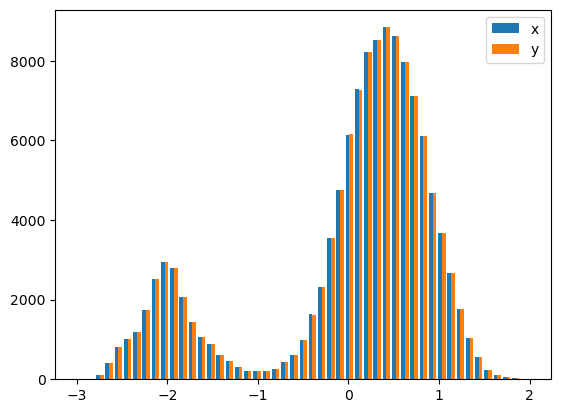

In [23]:
import matplotlib.pyplot as plt

x=processor.X[0]
y = processor.kaggle_test_data[0]

bins = np.linspace(-3, 2, 50)

plt.hist([x,y], bins, label=['x', 'y'])
plt.legend(loc='upper right')
plt.show()

In [13]:
.describe()

count    1.191030e+05
mean     8.789930e-17
std      1.000000e+00
min     -2.959479e+00
25%     -1.677164e-01
50%      2.944010e-01
75%      6.503465e-01
max      5.278735e+00
Name: 0, dtype: float64

# Build solo models (see later for hyperparameter tuning)

## Preprocess the data
**Use the processor object to handle the data going forward**

In [3]:
processor = Processor(credit_X, credit_Y)
# Standardize dummify, and pad with B0. Numeric data is infered if no column names provided
processor.process_data()

## Choose a split type ('random', 'stratified_class', 'set_class_prop_undersample')

'random' performs random selection. 'stratified_class' ensures that the train, dev, and test set each have the same proportions of each class as the overall dataset (\~93% 0 and 7% 1). 'set_class_prop_undersample' requires the 'class_prop_1_0' parameter to be set (ratio between # of 1s / # of 0s) and forces the training set to have this ratio of class levels. Note that the dev and test sets will have stratified class levels at the overall dataset ratio (\~ 93% 0 and 7% 1).

**random**

In [4]:
processor.calculate_train_dev_test_split(split_type='random', train_prop=.8, dev_prop=.1)

train_X, train_Y, dev_X, dev_Y, test_X, test_Y = processor.get_train_dev_test_sets()

train_X.shape, train_Y.shape, dev_X.shape, dev_Y.shape, test_X.shape, test_Y.shape

((95282, 133), (95282,), (11911, 133), (11911,), (11910, 133), (11910,))

**stratified_class**

Note: the calculated train, dev, and test sets are saved and can be accessed by the .get_train_dev_test_sets function. Re-running .calculate_train_dev_test_split() re-calculates the dataset splits

In [5]:
processor.calculate_train_dev_test_split(split_type='stratified_class', train_prop=.8, dev_prop=.1)

train_X, train_Y, dev_X, dev_Y, test_X, test_Y = processor.get_train_dev_test_sets()

pd.Series(train_Y).value_counts() / len(train_Y), pd.Series(dev_Y).value_counts() / len(dev_Y), pd.Series(test_Y).value_counts() / len(test_Y)

Re-calculating train, dev, and test sets


(0    0.93112
 1    0.06888
 dtype: float64,
 0    0.931072
 1    0.068928
 dtype: float64,
 0    0.93115
 1    0.06885
 dtype: float64)

**set_class_prop_undersample**

Note: train_prop is ignored here (the size of the training set is determined by how large the dev/test sets are and the 1/0 class level ratio).

In [6]:
processor.calculate_train_dev_test_split(split_type='set_class_prop_undersample', dev_prop=.03, class_prop_1_0=1)

train_X, train_Y, dev_X, dev_Y, test_X, test_Y = processor.get_train_dev_test_sets()

train_Y.shape, dev_Y.shape, test_Y.shape, pd.Series(train_Y).value_counts()

Re-calculating train, dev, and test sets


((15424,),
 (3573,),
 (3573,),
 0    7712
 1    7712
 dtype: int64)

## Build solo models w/ preprocessed data
**Available models: 'Logistic', 'Logistic Lasso', 'SVC', 'SVC_C', 'LDA'**

Note: gradient descent defaults to
- max_iterations=75000
- tol = 1e-3
- etas = [.1, .01, .001, .0001, .00001, .000001]

You can modify these by passing in named variables to any model '.fit()' function

If you would like to turn off output as gradient descent trys each eta value, use 'show_iter=False'

In [58]:
logistic = Model('Logistic')
logistic.fit(train_X, train_Y, max_iterations=5000, etas=[.1, 5e-4], show_iter=True)

Eta: 0.1; Iterations: 3
Eta: 0.0005; Iterations: 5000
GRADIENT DID NOT CONVERGE. RESULTS ARE BAD


Any models that require a lambda value requires that it is provided when the model is created (lamb=)

In [26]:
logistic = Model('Logistic Lasso', lamb=1)
logistic.fit(train_X, train_Y, show_iter=False)

In [27]:
svc = Model('SVC', lamb=1)
svc.fit(train_X, train_Y, show_iter=False)

Access any modles coefficients via '.coef_'

In [30]:
svc.coef_[:10]

array([ 0.00000000e+00,  9.49645789e-06,  1.30141738e-05, -4.68515224e-05,
       -3.00345191e-05, -6.14864012e-05,  1.49985113e-04, -8.22653154e-05,
        5.92100506e-05,  9.42785972e-05])

LDA '.coef_' returns a 2-dimensional tuple where [0] holds B and [1] holds the cutoff value (c) for which XB >= C is class 1.

In [ ]:
lda = Model('LDA')
lda.fit(train_X, train_Y)
lda.coef_

## Make predictions and score

In [10]:
predictions = logistic.predict(dev_X, dev_Y)
display(confusion_matrix(predictions, dev_Y))
'Accuracy: ', accuracy(predictions, dev_Y)

,True 1,True 0
Pred 1,171,1108
Pred 0,89,2461


('Accuracy: ', 0.6873857404021938)

# Run some analysis of class level ratios in training set

In [15]:
ratios = np.linspace(0, 2, num=21)
fscores = []
accuracies = []
roc_aucs = []
saved_predictions = []
for class_ratio in ratios:
    # Get splits for the class_ratio
    processor.calculate_train_dev_test_split(split_type='set_class_prop_undersample', dev_prop=.03, 
                                             class_prop_1_0=class_ratio, silence=True)
    train_X, train_Y, dev_X, dev_Y, test_X, test_Y = processor.get_train_dev_test_sets()
    # Train model and get predictions on the dev set
    logisticLasso = Model('Logistic Lasso', lamb=1)
    logisticLasso.fit(train_X, train_Y, max_iterations=4000, etas=[1e-4, 1e-5], show_iter=True)
    predictions = logisticLasso.predict(dev_X, dev_Y)
    saved_predictions.append(predictions)
    fscores.append(fmeasure(predictions, dev_Y, B=5))
    accuracies.append(accuracy(predictions, dev_Y))
    roc_aucs.append(roc_auc(predictions, dev_Y))

Eta: 0.0001; Iterations: 4000
Eta: 0.0001; Iterations: 4000
GRADIENT DID NOT CONVERGE. RESULTS ARE BAD
Eta: 0.0001; Iterations: 4000
Eta: 0.0001; Iterations: 4000
GRADIENT DID NOT CONVERGE. RESULTS ARE BAD
Eta: 0.0001; Iterations: 4000
Eta: 0.0001; Iterations: 4000
GRADIENT DID NOT CONVERGE. RESULTS ARE BAD
Eta: 0.0001; Iterations: 4000
Eta: 0.0001; Iterations: 4000
GRADIENT DID NOT CONVERGE. RESULTS ARE BAD
Eta: 0.0001; Iterations: 4000
Eta: 0.0001; Iterations: 4000
GRADIENT DID NOT CONVERGE. RESULTS ARE BAD
Eta: 0.0001; Iterations: 4000
Eta: 0.0001; Iterations: 4000
GRADIENT DID NOT CONVERGE. RESULTS ARE BAD
Eta: 0.0001; Iterations: 4000
Eta: 0.0001; Iterations: 4000
GRADIENT DID NOT CONVERGE. RESULTS ARE BAD
Eta: 0.0001; Iterations: 4000
Eta: 0.0001; Iterations: 4000
GRADIENT DID NOT CONVERGE. RESULTS ARE BAD
Eta: 0.0001; Iterations: 4000
Eta: 0.0001; Iterations: 4000
GRADIENT DID NOT CONVERGE. RESULTS ARE BAD
Eta: 0.0001; Iterations: 4000
Eta: 0.0001; Iterations: 4000
GRADIENT DID 

In [17]:
import altair as alt

data = pd.DataFrame({
    'Ratios': ratios,
    'F-5': fscores,
    'ROC-AUC': roc_aucs,
    'Accuracy': accuracies
})

In [18]:
alt.Chart(data).mark_line().encode(
    x='Ratios',
    y='ROC-AUC'
)

alt.Chart(...)

In [19]:
alt.Chart(data).mark_line().encode(
    x='Ratios',
    y='F-5'
)

alt.Chart(...)

In [20]:
alt.Chart(data).mark_line().encode(
    x='Ratios',
    y='Accuracy'
)

alt.Chart(...)

# Run multiple models at once and do hyperparameter tuning

## Use the 'ModelGridBuilder' class to create multiple models at once to test

In [38]:
logisticSearchBuilder = ModelGridBuilder('Logistic Lasso', parameters=[0, .25, .5, 1, 1.5, 2])
svcSearchBuilder = ModelGridBuilder('SVC', parameters=[0, .25, .5, 1, 1.5, 2])
ldaSearchBuilder = ModelGridBuilder('LDA')

**Save all models created into a single list**

In [39]:
models = logisticSearchBuilder.get_models() + svcSearchBuilder.get_models() + ldaSearchBuilder.get_models()

## Use the 'AnalysisPipeline' class to create a grid search over the provided models
**Provide AnalysisPipeline with the unprocessed X and Y data, models, and a scoring function to be used on the dev/test sets**

Run '.process_data()' to process the data via the input split type (see notes on the Processor object above)

Run '.fit_models()' to fit every model provided on the processed data (can pass in gradient descent variables as above)

In [42]:
modelAnalysis = AnalysisPipeline(credit_X, credit_Y, models, roc_auc)
modelAnalysis.process_data(split_type='stratified_class', train_prop=.8, dev_prop=.1)
modelAnalysis.fit_models(max_iterations=1000, etas=[.001])

**Run predictions on the dev set for every model and determine which one is best via '.test_models()'**

**Output all of the computed scores for each model via '.dev_set_analysis'**

In [ ]:
best_model_specs, conf_mat = modelAnalysis.test_models()
display(conf_mat)
best_model_specs, modelAnalysis.dev_set_analysis

**Change the scoring function and retest the models**

In [ ]:
modelAnalysis.score_func = lambda p, Y: fmeasure(p, Y, B=10)

best_model_specs, conf_mat = modelAnalysis.test_models()
display(conf_mat)
best_model_specs, modelAnalysis.dev_set_analysis

**Get the test set scores for the best model**

In [ ]:
modelAnalysis.testscore_best_model()